# Soft Actor-Critic Implementation

### *Pol Roca Llaberia*

This notebook contains a simple implementation and evaluation of the Soft Actor-Critic (SAC) algorithm to train a stochastic actor in a continuous environment.

In [ ]:
import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

### Choose whether to use GPU or CPU

In [ ]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda x: x.cuda() if USE_CUDA else x

## Instantiate environment

In [ ]:
!pip install box2d

In [ ]:
# env_id = "MountainCarContinuous-v0"
env_id = "LunarLanderContinuous-v2"
env = gym.make(env_id)
env_test = gym.make(env_id)
env.reset()
env_test.reset()

n_obs = env.observation_space.shape[0]
n_act = env.action_space.shape[0]

print('State dim:', n_obs)
print('Num actions:', n_act)
print('Observation limits:\n', env.observation_space.high)
print(env.observation_space.low)

print('Action limits:\n', env.action_space.high)
print(env.action_space.low)

State dim: 8
Num actions: 2
Observation limits:
 [inf inf inf inf inf inf inf inf]
[-inf -inf -inf -inf -inf -inf -inf -inf]
Action limits:
 [1. 1.]
[-1. -1.]


Because actions in these environments can take values from the range [0, 1] just as the output of the actor model, we won't apply any scaling or adaptation. 

<h2>Replay Buffer</h2>

In [ ]:
class ReplayBuffer(object):
    def __init__(self, n_obs, n_act, capacity):
        self.next = 0
        self.capacity = capacity
        self.buffer = np.zeros((capacity, n_obs*2 + n_act + 2), dtype=np.float32)
        self.col_idx = (slice(n_obs),                # state
                        slice(n_obs, n_obs+n_act),   # action
                        (n_obs+n_act,),              # reward
                        slice(n_obs+n_act+1, -1),    # next_state
                        (-1,))                       # done
    
    def push(self, state, action, reward, next_state, done):
        n = self.next % self.capacity
        self.buffer[n] = *state, *action, reward, *next_state, done
        self.next += 1
    
    def sample(self, batch_size, replace=False):
        idx = np.random.choice(len(self), batch_size, replace=replace)
        batch = self.buffer[idx]
        return [Variable(torch.as_tensor(batch[:, cols])) for cols in self.col_idx]
    
    def __len__(self):
        return np.min([self.next, self.capacity])

## Critic Q-value NN model

In [ ]:
class Critic(nn.Module):
    def __init__(self, n_dim, layer_units=128):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(n_dim, layer_units),
            nn.ReLU(),
            nn.Linear(layer_units, layer_units),
            nn.ReLU(),
            nn.Linear(layer_units, 1))
        
    def forward(self, state, action):
        x = torch.cat((state, action), dim=1)
        return self.layers(x)

In [ ]:
critic1 = Critic(n_obs + n_act)
critic2 = Critic(n_obs + n_act)
critic1_target = Critic(n_obs + n_act)
critic2_target = Critic(n_obs + n_act)

if USE_CUDA:
    critic1 = critic1.cuda()
    critic2 = critic2.cuda()
    critic1_target = critic1_target.cuda()
    critic2_target = critic2_target.cuda()

# start with the same weights
critic1_target.load_state_dict(critic1.state_dict())
critic2_target.load_state_dict(critic2.state_dict())

critics = [
    critic1, critic1_target,
    critic2, critic2_target,
]

## Actor Policy NN model

In [ ]:
class Actor(nn.Module):
    def __init__(self, n_obs, n_act, layer_units=128, logsigma_min=-20, logsigma_max=2):
        super().__init__()
        
        self.n_act = n_act
        self.logsigma_min = logsigma_min
        self.logsigma_max = logsigma_max

        self.layers = nn.Sequential(
            nn.Linear(n_obs, layer_units),
            nn.ReLU(),
            nn.Linear(layer_units, layer_units),
            nn.ReLU())
        self.out_mu = nn.Linear(layer_units, n_act)
        self.out_logsigma = nn.Linear(layer_units, n_act)
        
    def forward(self, state, return_log_prob=True, explore=True):
        y = self.layers(state)
        mu = self.out_mu(y)

        # when using the agent outside of training, return the (squashed) mean
        if not explore:
            return torch.tanh(mu)

        logsigma = self.out_logsigma(y)
        # clip to prevent exploding values
        logsigma = torch.clamp(logsigma, self.logsigma_min, self.logsigma_max)
        # consider the output as a logarithm so that sigma is always positive
        sigma = torch.exp(logsigma)

        # sample from the distribution
        dist = Normal(mu, sigma)
        action = dist.rsample() # this does the reparameterization trick
        action_sq = torch.tanh(action) # squash
        
        # when deciding an action to be performed in an actual environment, 
        # probabilities are not needed so we avoid unnecessary computations
        if not return_log_prob:
            return action_sq

        # adapt probabilities (approx) because we squash the action using tanh
        log_prob = dist.log_prob(action).sum(axis=-1)
        log_prob -= (2 * (np.log(2) - action \
                     - nn.functional.softplus(-2*action))).sum(axis=1)
        return action_sq, log_prob

    def act(self, state, explore=True):
        with torch.no_grad():
            state = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0))
            action = self.forward(state, explore=explore, return_log_prob=False)
            return action[0].cpu().numpy()

In [ ]:
actor = Actor(n_obs, n_act).cuda() if USE_CUDA else Actor(n_obs, n_act)

## Actor-Critic Loss

In [ ]:
class SAC:
    def __init__(self,
                 actor,
                 critics,
                 replay_buffer,
                 optimizer=optim.Adam,
                 batch_size=64,
                 gamma=0.99,
                 ro=0.995,
                 reward_scale=1,
                 alpha_start=1.0,
                 alpha_final=0.1,
                 alpha_decay=3e4,
                 init_delay=5e3,
                 update_every=50):
        
        self.actor = actor
        self.critic1, self.critic1_target, \
          self.critic2, self.critic2_target = critics
        self.replay_buffer = replay_buffer

        self.batch_size = batch_size
        self.gamma = gamma
        self.ro = ro
        self.reward_scale = reward_scale
        self.alpha_start = alpha_start
        self.alpha_final = alpha_final
        self.alpha_decay = alpha_decay
        self.init_delay = init_delay
        self.update_every = update_every
            
        self.optim1 = optimizer(self.critic1.parameters())
        self.optim2 = optimizer(self.critic2.parameters())
        self.optim3 = optimizer(self.actor.parameters())  
        
        self.losses_critic = []
        self.losses_actor = []      
        self.t = 0

    def act(self, state, explore=True):
        return self.actor.act(state, explore=explore)

    def feedback(self, state, action, reward, next_state, done):
        reward *= self.reward_scale
        self.replay_buffer.push(state, action, reward, next_state, done)

        if self.t >= self.init_delay and self.t % self.update_every == 0:
            for _ in range(self.update_every):
                self.alpha = self._alpha_by_timestep(self.t)
                batch = self.replay_buffer.sample(self.batch_size)
                loss_critic = self._update_critic(batch)
                loss_actor = self._update_actor(batch)
                self._update_critic_target()
                self.losses_critic.append(loss_critic.item())
                self.losses_actor.append(loss_actor.item())
        
        self.t += 1

    def _alpha_by_timestep(self, t):
        return self.alpha_final + (self.alpha_start - self.alpha_final) \
               * np.exp(-1. * t / self.alpha_decay)

    def _update_critic(self, batch):
        state, action, reward, next_state, done = batch

        with torch.no_grad():
            next_action, next_log_prob = self.actor(next_state)
            q_value1_target = self.critic1_target(next_state, next_action)
            q_value2_target = self.critic2_target(next_state, next_action)
            min_q_value_target = torch.min(q_value1_target, q_value2_target)

            y = reward + (1. - done) * self.gamma * (min_q_value_target - self.alpha * next_log_prob)

        q_value1 = self.critic1(state, action)
        q_value2 = self.critic2(state, action)
        loss_critic1 = (q_value1 - y).pow(2).mean()
        loss_critic2 = (q_value2 - y).pow(2).mean()
            
        self.optim1.zero_grad()
        loss_critic1.backward()
        self.optim1.step()

        self.optim2.zero_grad()
        loss_critic2.backward()
        self.optim2.step()

        return loss_critic1 + loss_critic2

    def _update_actor(self, batch):
        state, action, reward, next_state, done = batch
        
        action, log_prob = self.actor(state)
        q_value1 = self.critic1(state, action)
        q_value2 = self.critic2(state, action)
        min_q_value = torch.min(q_value1, q_value2)
        
        loss_actor = (self.alpha * log_prob - min_q_value).mean()

        self.optim3.zero_grad()
        loss_actor.backward()
        self.optim3.step()

        return loss_actor

    def _update_critic_target(self):
        # this performs a polyak update with parameter ro
        # note that here ro represents the part that is kept from the target
        # network (sometimes in the papers it is 1 - ro)
        with torch.no_grad():
            for c1, c2, c1t, c2t in zip(self.critic1.parameters(), 
                                        self.critic2.parameters(),
                                        self.critic1_target.parameters(), 
                                        self.critic2_target.parameters()):
                c1t.data.mul_(self.ro)
                c1t.data.add_((1. - self.ro) * c1.data)

                c2t.data.mul_(self.ro)
                c2t.data.add_((1. - self.ro) * c2.data)

We will define a function to evaluate the evolution in performance of the agent throughout training.

In [ ]:
def rollout(agent, env, n):
    all_rewards = []
    for _ in range(n):
        episode_reward = 0
        done = False
        state = env.reset()
        while not done:
            action = agent.act(state, explore=False)    
            state, reward, done, _ = env.step(action)
            episode_reward += reward
        all_rewards.append(episode_reward)
    return np.min(all_rewards), np.mean(all_rewards), np.max(all_rewards)

And also a function to plot that and some metrics on the go.

In [ ]:
def plot(t, rewards, critic_loss, actor_loss):
    clear_output(True)

    rewards = np.array(rewards)
    plt.figure(figsize=(20, 5))
    plt.subplot(131)
    plt.title(f'frame: {t} reward: {round(rewards[-1, 1], 2)}')
    plt.plot(rewards[:, 1])
    plt.fill_between(x=range(len(rewards)), 
                     y1=rewards[:, 0], 
                     y2=rewards[:, 2],
                     alpha=0.2)

    plt.subplot(132)
    plt.title('critic loss')
    plt.plot(critic_loss)

    plt.subplot(133)
    plt.title('actor loss')
    plt.plot(actor_loss)
    plt.show()

<h2>Training</h2>

In [ ]:
replay_buffer = ReplayBuffer(n_obs, n_act, int(1e5))

sac = SAC(actor=actor,
          critics=critics,
          replay_buffer=replay_buffer,
          batch_size=128,
          gamma=0.99,
          ro=0.997,
          reward_scale=3,
          alpha_start=1.0,
          alpha_final=0.01,
          alpha_decay=35000,
          init_delay=10000,
          update_every=50)

Here we can see how the exploration will decay over time, given some specific parameters

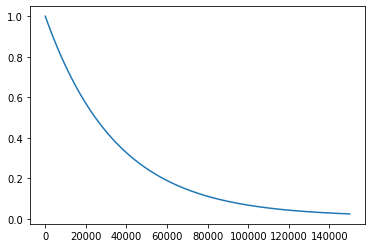

In [ ]:
plt.plot([sac._alpha_by_timestep(t) for t in range(150000)])

This is the general main loop for training an agent

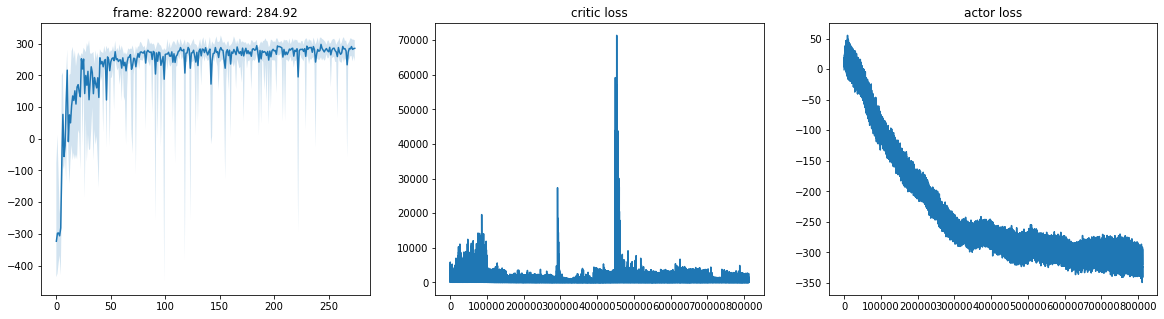

In [ ]:
n_steps = 1000000
eval_every = 3000
eval_rewards = []

state = env.reset()
for t in range(n_steps):

    action = sac.act(state)    
    next_state, reward, done, _ = env.step(action)
    sac.feedback(state, action, reward, next_state, done)    
    state = next_state
    
    if done:
        state = env.reset()
    
    if t % eval_every == 0:
        eval_rewards.append(rollout(sac, env_test, 10))
        plot(t, eval_rewards, sac.losses_critic, sac.losses_actor)


### Observations

In the LunarLander environment we can see that the agent is able to successfully learn a decent policy (see results above). 

This is the best combination of hyperparameters that I could find. In addition, I also experimented with combinations of the following values:
- capacity (replay_buffer): (1000, 3000, 5000, 7500, 10000, **100000**)
- batch_size: (64, **128**, 256)
- ro: (0.995, **0.997**, 0.999)
- reward_scale: (1, **3**, 5)
- alpha_decay: (15000, 20000, 25000, 30000, **35000**)
- update_every: (**50**, 100)
- layer units of Critic and Actor models: (**128**, 256)

Both networks had an architecture of 2 hidden layers in all experiments because I did not think that the reward function required more complexity to be approximated.

The init_delay parameter of SAC was almost always set to 10000 in order to let the buffer fill up a bit, and also to enforce some initial exploration since the first actions are expected to be random (with the networks weights initialized randomly).

Besides, I could not achieve any interesting results with the MountainCar environment because the agent did not seem to be able to reach the goal, and developing a useful policy depended too much on that act (I did not experiment as much with it either).